##                                   AIM 5001 Final Project
####                                                                             By Zeyu Wang

# 1. Abstract：
Last few years, many countries have had a quick development and the GDP is the main indicator used to describe a country's development. In this project, we will research several other indicators that also have a relationship with GDP and these indicators are important for the country's development and will be beneficial for the political researcher in their research.

# 2. Introduction: 
In this project, I would like to analyze several indicators such as CO2 emissions, Commercial service exports,  Commercial service imports, Communications computer exports, Communications computer imports and  Current health expenditure per capita and observed do they have a relationship with GDP? 
- Firstly, I need to get the data. I will get GDP data from INF and these several indicators from The World Bank Data.INF(https://www.imf.org/en/Publications/WEO/weo-database/2021/April/weo-report?c=512,914,612,614,311,213,911,314,193,122,912,313,419,513,316,913,124,339,638,514,218,963,616,223,516,918,748,618,624,522,622,156,626,628,228,924,233,632,636,634,238,662,960,423,935,128,611,321,243,248,469,253,642,643,939,734,644,819,172,132,646,648,915,134,652,174,328,258,656,654,336,263,268,532,944,176,534,536,429,433,178,436,136,343,158,439,916,664,826,542,967,443,917,544,941,446,666,668,672,946,137,546,674,676,548,556,678,181,867,682,684,273,868,921,948,943,686,688,518,728,836,558,138,196,278,692,694,962,142,449,564,565,283,853,288,293,566,964,182,359,453,968,922,714,862,135,716,456,722,942,718,724,576,936,961,813,726,199,733,184,524,361,362,364,732,366,144,146,463,528,923,738,578,537,742,866,369,744,186,925,869,746,926,466,112,111,298,927,846,299,582,487,474,754,698,&s=NGDPD,&sy=2006&ey=2020&ssm=0&scsm=0&scc=0&ssd=0&ssc=0&sic=0&sort=country&ds=.&br=1) and The World Bank Data(https://datahelpdesk.worldbank.org/knowledgebase/topics/125589-developer-information)
- Secondly, after I get the data from the INF which it's the dynamic web pages, I store them into the MongoDB database and will take them out when I need them.
- Thirdly, I will use WebApi to get data from the World Bank Data and use them to form three Pandas datasets which will including the GDP.
- Finally, I will draw several graphs to compare their relationship and know are they positive correlation or negative correlation. The result will be beneficial for some relative scientists.

# 3. Research Approach: 
I will use some relative technology to deal with my data. For example, I need to use statistical knowledge suck as variance to help me decide which country can help me to get the answer rather than use all of the data. And I will use data reshaping operation to help me better understand the data. Also, for getting a better result, I need to use feature engineering methods such as feature scaling. Furthermore, grouping also will be used in this project. Finally, comparing the trends in the line chart to make sure their relationship is the method I will take to find their relationship because I think this method is most direct to get the answer.

# 4.Exploratory Data Analysis & Data Preparation

In [84]:
import bs4 as bs
import urllib.request
import requests
import sys
from PyQt5.QtCore import QEventLoop,QUrl
from PyQt5.QtWidgets import QApplication
from PyQt5.QtWebEngineWidgets import QWebEngineView
import lxml.html
import re
import pandas as pd
import numpy as np
import psycopg2
import pymongo
from pymongo import MongoClient
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import seaborn as sns
import time

#### 4.1 Get GDP's data. In this part, we will get the data and do some EDA work for the data.

##### 4.1.1 Because the INF website is a dynamic webpage and it's hard to get by a general method. So we need to use pyqt5 to imitate the browser to get the data from the INF and then parsing the data. The following code is used to imitate the browser and get the dynamic web pages' data.

In [3]:
def render(url):
    """Fully render HTML, JavaScript and all."""


    class Render(QWebEngineView):
        def __init__(self, url):
            self.html = None
            self.app = QApplication(sys.argv)
            QWebEngineView.__init__(self)
            self.loadFinished.connect(self._loadFinished)
            self.load(QUrl(url))
            while self.html is None:
                self.app.processEvents(QEventLoop.ExcludeUserInputEvents | QEventLoop.ExcludeSocketNotifiers | QEventLoop.WaitForMoreEvents)
            self.app.quit()

        def _callable(self, data):
            self.html = data

        def _loadFinished(self, result):
            self.page().toHtml(self._callable)

    return Render(url).html


##### 4.1.2Get the data about the ECONOMIES' GDP. First, we need to choose all of the countries on the INF website. After that, we can get a URL which is a dynamic webpage including the GDP data.

In [4]:
develop_country_GDP = render('https://www.imf.org/en/Publications/WEO/weo-database/2021/April/weo-report?c=512,914,612,614,311,213,911,314,193,122,912,313,419,513,316,913,124,339,638,514,218,963,616,223,516,918,748,618,624,522,622,156,626,628,228,924,233,632,636,634,238,662,960,423,935,128,611,321,243,248,469,253,642,643,939,734,644,819,172,132,646,648,915,134,652,174,328,258,656,654,336,263,268,532,944,176,534,536,429,433,178,436,136,343,158,439,916,664,826,542,967,443,917,544,941,446,666,668,672,946,137,546,674,676,548,556,678,181,867,682,684,273,868,921,948,943,686,688,518,728,836,558,138,196,278,692,694,962,142,449,564,565,283,853,288,293,566,964,182,359,453,968,922,714,862,135,716,456,722,942,718,724,576,936,961,813,726,199,733,184,524,361,362,364,732,366,144,146,463,528,923,738,578,537,742,866,369,744,186,925,869,746,926,466,112,111,298,927,846,299,582,487,474,754,698,&s=NGDPD,&sy=2006&ey=2020&ssm=0&scsm=0&scc=0&ssd=0&ssc=0&sic=0&sort=country&ds=.&br=1')

##### 4.1.3 After getting the data from INF, we use bs4 to extract the LXML data.

In [5]:
soup_neg = bs.BeautifulSoup(develop_country_GDP,'lxml')

In [6]:
name_neg_str = ''
for name_neg in soup_neg.find_all('tbody'):
    name_neg_str = name_neg.text
    name_neg_str = name_neg_str.replace('\n',' ')
    #print(name_neg_str)
pattern = re.compile(r'[A-Za-z\s.]+[0-9.,\s]+')#this re is used to extract the country name and GDP data from the string.
name_neg_list = re.findall(pattern, name_neg_str)
name_neg_list
country_name = []
country_GDP = []
for i in name_neg_list:
    a_data = i.split(' U.S. dollars Billions   ')
    if len(a_data)==1:# some country's name has non_english letter and we will ignore them
        continue
    a_data[1] = a_data[1][:-8]
    a_data[1] = a_data[1].replace(',','')
    a_data[1].split(' ')
    if len(a_data[1].split(' '))!=15:#some country doesn't have 15 years GDP data and we will ignore them
        continue
    a_data[0] = a_data[0].replace('.',' ')
    country_name.append(a_data[0])
    country_GDP.append(a_data[1].split(' '))
#We have 192 country's data
year = [i for i in range(2006, 2021)]
df_gdp = pd.DataFrame(index = country_name, data = country_GDP, columns = year, dtype=np.float)
df_gdp

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Afghanistan,6.925,8.556,10.297,12.066,15.325,17.890,20.293,20.170,20.635,20.220,17.994,18.910,18.401,18.876,19.132
Albania,8.896,10.677,12.881,12.044,11.937,12.899,12.324,12.784,13.246,11.389,11.862,13.053,15.147,15.276,15.147
Algeria,117.027,134.977,171.001,137.054,161.207,200.251,209.059,209.755,213.810,165.979,160.034,170.207,175.367,171.070,144.294
Angola,52.381,65.266,88.539,70.307,83.799,111.790,128.053,136.710,145.712,116.194,101.124,122.124,105.902,89.603,62.440
Antigua and Barbuda,1.157,1.311,1.368,1.224,1.149,1.138,1.200,1.181,1.250,1.337,1.437,1.468,1.605,1.662,1.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,84.301,98.429,124.774,129.054,143.257,171.368,195.168,212.738,232.893,236.840,252.149,277.074,304.016,329.537,340.821
West Bank and Gaza,5.348,5.816,7.310,8.086,9.682,11.186,12.208,13.516,13.990,13.972,15.405,16.128,16.277,17.134,15.519
Yemen,19.063,21.651,26.911,25.130,30.907,32.726,35.401,40.415,43.229,42.445,30.934,26.736,23.486,22.568,20.140
Zambia,12.762,14.060,17.914,15.332,20.264,23.455,25.502,28.042,27.145,21.245,20.965,25.874,26.312,23.309,18.529


#### We get this data set which is 192 countries and 15 years of GDP data. The index of this Pandas dataset is the country's name. The unit of GDP is Billion.

#### 4.2 Store the data into NoSQL MongoDB because there is only one table and doesn't need to create the relationship.

In [7]:
client = MongoClient()
db = client['finalproject']#create a new database 'finalproject'
db = client.finalproject

In [8]:
def MongodbInsertDAta(colloection, post):
    '''
    This function will get a collection name and use it to create a new collection in MongoDB.
    This function will insert the post into MongoDB so that post must be in a format that suits the MongoDB grammar.
    '''
    posts_collection = db[colloection]
    post_id = posts_collection.insert_many(post)

In [9]:
data_country = []
for i in range(len(country_name)):
    name = country_name[i]
    gdp = country_GDP[i]
    data_dict = {}# form the MongoDB grammar
    data_dict[name] = gdp
    data_country.append(data_dict)
#print(data_country)
MongodbInsertDAta("data_country", data_country)
client.close()

### We successfully store the data into MongoDB.

#### 4.3 get country GDP data from MongoDB

In [14]:
db = client.finalproject#choose Database finalproject and store into db
collection_data_country = db['data_country']#choose collection 'data_country'
cursor = collection_data_country.find()#select all the data from mogoDB's collection 'data_country'
entries = list(cursor)#change the data into list

In [15]:
entries

[{'_id': ObjectId('6095dddf3d4c5d067f566c6f'),
  '  Afghanistan': ['6.925',
   '8.556',
   '10.297',
   '12.066',
   '15.325',
   '17.890',
   '20.293',
   '20.170',
   '20.635',
   '20.220',
   '17.994',
   '18.910',
   '18.401',
   '18.876',
   '19.132']},
 {'_id': ObjectId('6095dddf3d4c5d067f566c70'),
  'Albania': ['8.896',
   '10.677',
   '12.881',
   '12.044',
   '11.937',
   '12.899',
   '12.324',
   '12.784',
   '13.246',
   '11.389',
   '11.862',
   '13.053',
   '15.147',
   '15.276',
   '15.147']},
 {'_id': ObjectId('6095dddf3d4c5d067f566c71'),
  'Algeria': ['117.027',
   '134.977',
   '171.001',
   '137.054',
   '161.207',
   '200.251',
   '209.059',
   '209.755',
   '213.810',
   '165.979',
   '160.034',
   '170.207',
   '175.367',
   '171.070',
   '144.294']},
 {'_id': ObjectId('6095dddf3d4c5d067f566c72'),
  'Angola': ['52.381',
   '65.266',
   '88.539',
   '70.307',
   '83.799',
   '111.790',
   '128.053',
   '136.710',
   '145.712',
   '116.194',
   '101.124',
   '122.124

In [166]:
#extract data from the form of Mongodb's dict
coun_name = []
coun_GDP = []
for i in entries:
    item = i.items()
    name, gdp = list(item)[1]
    coun_name.append(name)
    coun_GDP.append(gdp)

In [167]:
#create Pandas
df1_gdp = pd.DataFrame(index = coun_name, data = coun_GDP, columns = year, dtype=np.float)
df1_gdp

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Afghanistan,6.925,8.556,10.297,12.066,15.325,17.890,20.293,20.170,20.635,20.220,17.994,18.910,18.401,18.876,19.132
Albania,8.896,10.677,12.881,12.044,11.937,12.899,12.324,12.784,13.246,11.389,11.862,13.053,15.147,15.276,15.147
Algeria,117.027,134.977,171.001,137.054,161.207,200.251,209.059,209.755,213.810,165.979,160.034,170.207,175.367,171.070,144.294
Angola,52.381,65.266,88.539,70.307,83.799,111.790,128.053,136.710,145.712,116.194,101.124,122.124,105.902,89.603,62.440
Antigua and Barbuda,1.157,1.311,1.368,1.224,1.149,1.138,1.200,1.181,1.250,1.337,1.437,1.468,1.605,1.662,1.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,84.301,98.429,124.774,129.054,143.257,171.368,195.168,212.738,232.893,236.840,252.149,277.074,304.016,329.537,340.821
West Bank and Gaza,5.348,5.816,7.310,8.086,9.682,11.186,12.208,13.516,13.990,13.972,15.405,16.128,16.277,17.134,15.519
Yemen,19.063,21.651,26.911,25.130,30.907,32.726,35.401,40.415,43.229,42.445,30.934,26.736,23.486,22.568,20.140
Zambia,12.762,14.060,17.914,15.332,20.264,23.455,25.502,28.042,27.145,21.245,20.965,25.874,26.312,23.309,18.529


#### 4.4 Analysis of the GDP trends of the countrys

##### 4.4.1 Draw the country's GDP trends from 2006 to 2020.

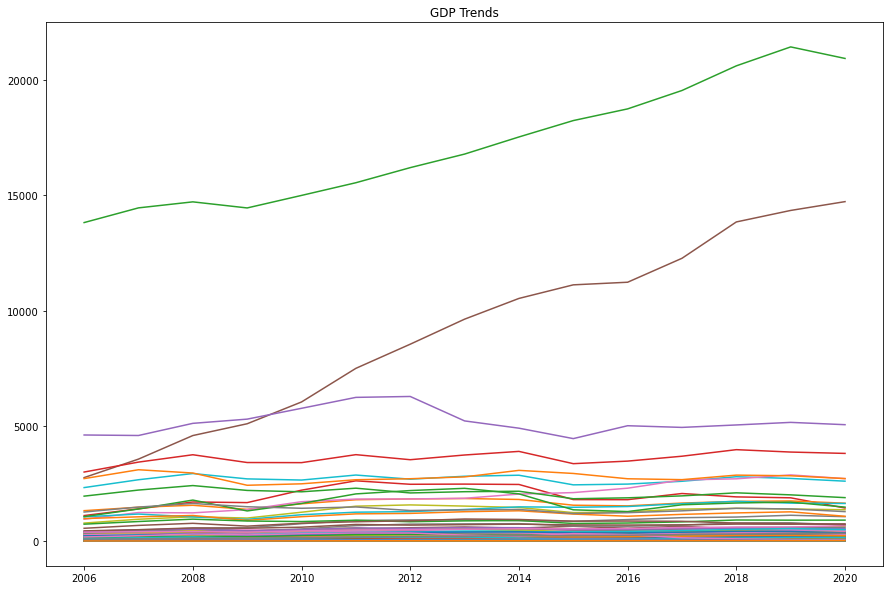

In [168]:
plt.figure(figsize=(15,10))
for i in range(len(df1_gdp)):
    plt.plot(year, df1_gdp.iloc[i,:], label=coun_name[i])
plt.title('GDP Trends')
#plt.legend()
plt.show()

#### From this graph, we can see that most of the countries GDP don't have obvious change and there are two country's GDP have a large change from 2006 to 2020. So I decide to choose two countries that have the largest variance and the country with the least variance. And then plus the sum of all the country's GDP which can help us to understand that the total GDP trends on the earth are growing. Finally, find some indicators which are a relationship with these five data.

##### 4.4.2 See what is the distribution of the GDP in 2020

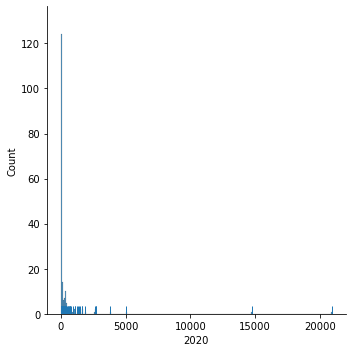

In [169]:
sns.displot(df1_gdp[2020], kde=False, rug=True)

#### We can see that because some of the country's GDP is very large although their unit is billion. We need to use feature engineering to deal with it. For example, we can use log transfer to deal with the data.

##### 4.4.2 See what is the distribution of the GDP by log transfer.

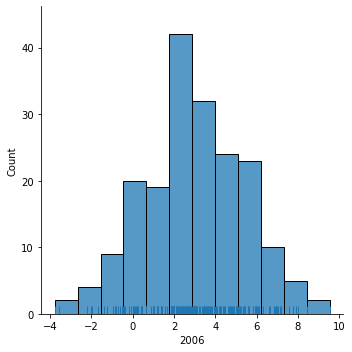

In [170]:
sns.displot(np.log(df1_gdp[2006]), kde=False, rug=True)

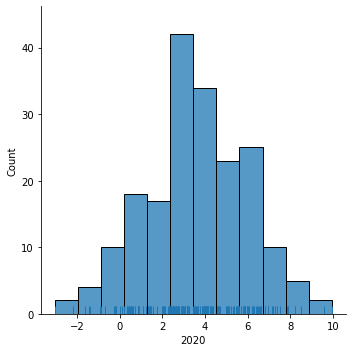

In [171]:
sns.displot(np.log(df1_gdp[2020]), kde=False, rug=True)

#### From these two graphs, we can see that the country's GDP is close to normal distribution. And from 2006 to 2020, Hight GDP countries is increasing between 5.8 to 7. We assume that the total country's GDP is growing and we can use mean to verify them.

##### 4.4.3 Verify the total GDP growth trends.

In [172]:
np.log(df1_gdp[2006]).mean()

2.9828859106315413

In [173]:
np.log(df1_gdp[2020]).mean()

3.5759692964874024

#### It's obviously that the total GDP in 2020 is greater than 2006

In [174]:
total_gdp_each_year = df1_gdp.mean()
total_gdp_each_year

2006    268.841828
2007    303.412193
2008    332.702776
2009    315.215776
2010    344.692396
2011    382.829922
2012    390.083214
2013    401.381760
2014    412.166469
2015    390.196464
2016    396.620755
2017    420.967115
2018    447.312583
2019    454.876109
2020    440.253552
dtype: float64

<AxesSubplot:>

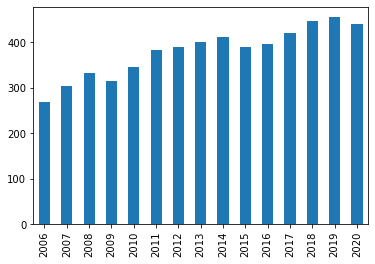

In [175]:
total_gdp_each_year.plot.bar()

#### There are several year's total GDP is reducing but the total trends are increasing.

##### 4.4.4 See what are the country have the most mean GDP from 2006 to 2020

No handles with labels found to put in legend.


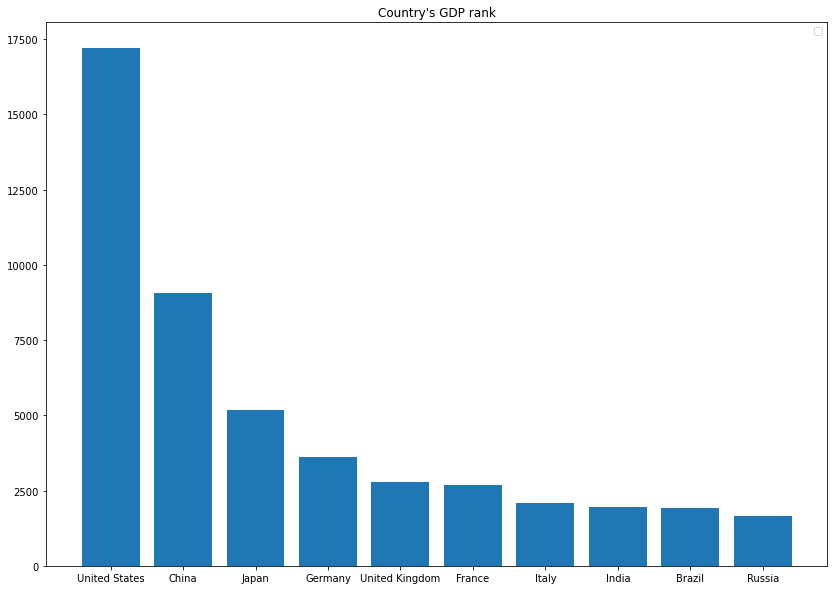

In [176]:
df_eda = df1_gdp
df_eda = df_eda.T
country_mean = df_eda.mean().sort_values(ascending=False)
country_mean10 = country_mean.head(10)
plt.figure(figsize = (14,10))
plt.title('Country\'s GDP rank')
plt.bar(country_mean10.index, country_mean10)
plt.legend()

#### It's clear to know United States has the meanest GDP which is more than 16000 billion from 2006 to 2020. Here is the country whose GDP mean is top 10 from 2006 to 2020.

##### 4.4.4 See what happens for the top5 country's GDP change from 2006 to 2020.

No handles with labels found to put in legend.


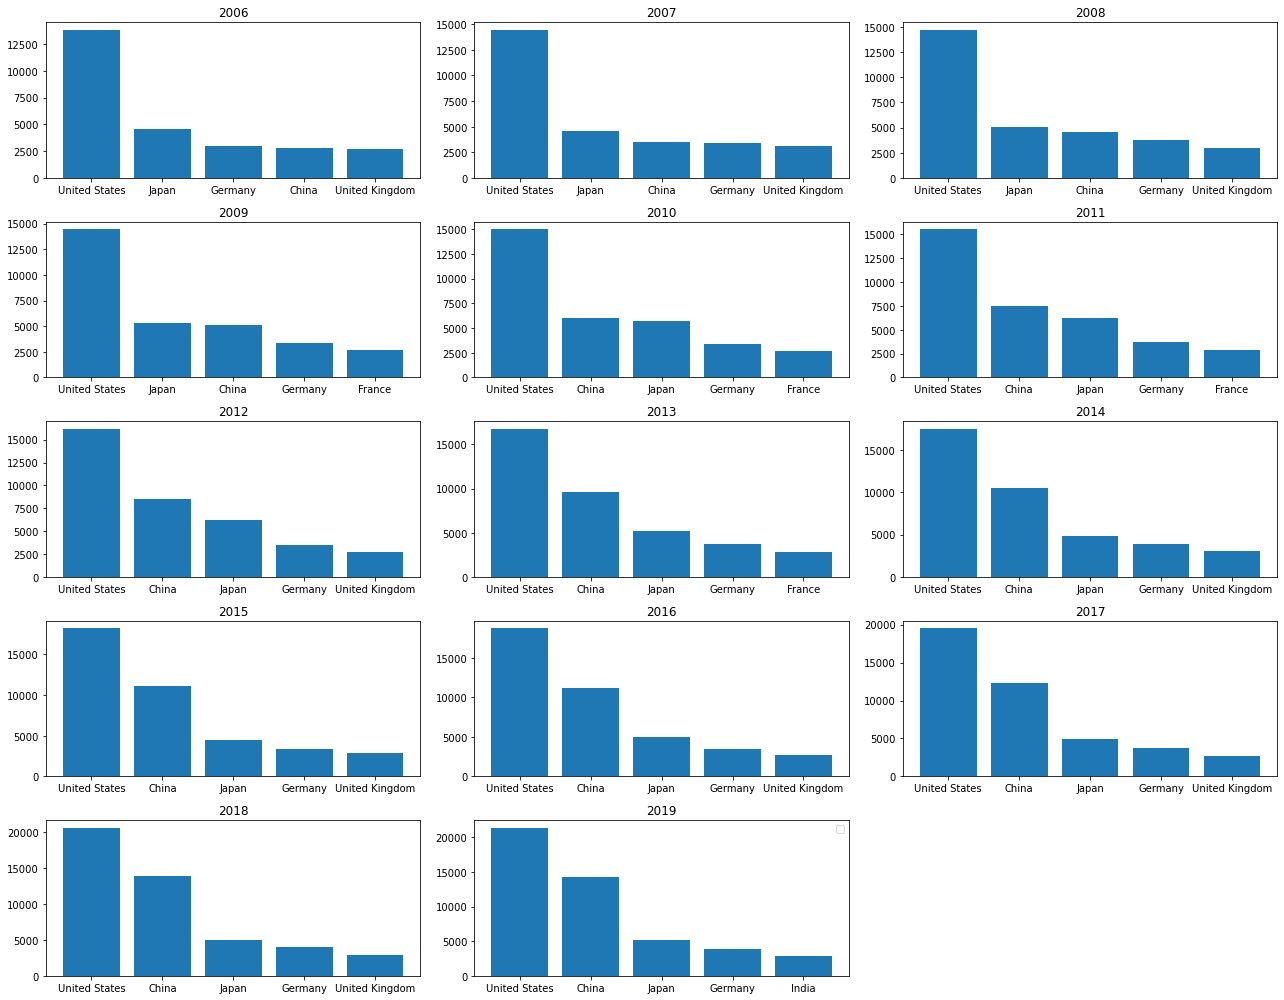

In [177]:
country_trend1 = df1_gdp
plt.figure(figsize = (18,14))
j = 0
for i in range(2006,2020):
    j = j+1
    plt.subplot(5,3,j)
    plt.bar(country_trend1[i].sort_values(ascending=False).head(5).index, country_trend1[i].sort_values(ascending=False).head(5))
    plt.title(i)
plt.legend()
plt.tight_layout()

#### In these 15 years, the united states are always the top 1 in the GDP rank. France fell out of the top ten. India enter the top 5

## Conclusion: From 2006 to 2020, United States has the best GDP performemce. Other country's GDP rank has a little change. The total GDP's trends are growing and this is beneficial for our later research because GDP has the same trends and we only need to observe the other indicator's trends as the GDP growth.

#### 4.5 Get some indicators data from The World Bank Data

##### 4.5.1 We need to make sure which country we will use to analyze the GDP data.

In [178]:
df1_gdp['var'] = np.var(df1_gdp, axis = 1)# We add a varriance attribute for the data

In [179]:
df2_gdp = df1_gdp.sort_values(by='var', ascending=False)

In [180]:
df2_gdp

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,var
China,2754.113,3555.679,4577.397,5088.993,6033.813,7492.257,8539.472,9625.044,10524.211,11113.528,11227.075,12265.317,13841.901,14340.600,14722.837,1.481852e+07
United States,13814.600,14451.875,14712.825,14448.925,14992.050,15542.600,16197.050,16784.825,17527.275,18238.300,18745.100,19542.975,20611.875,21433.225,20932.750,6.274959e+06
India,949.118,1238.700,1224.096,1365.373,1708.460,1823.052,1827.637,1856.721,2039.127,2103.588,2294.118,2651.474,2701.112,2870.504,2708.770,3.401986e+05
Japan,4601.663,4579.749,5106.679,5289.494,5759.072,6233.147,6272.364,5212.328,4896.995,4444.931,5003.678,4930.837,5036.892,5148.781,5048.688,2.734643e+05
Brazil,1107.628,1397.114,1695.855,1669.204,2208.704,2614.027,2464.054,2471.718,2456.055,1800.046,1796.622,2063.518,1916.934,1877.114,1434.084,1.856965e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Palau,0.189,0.195,0.198,0.184,0.184,0.193,0.212,0.224,0.244,0.279,0.297,0.288,0.285,0.280,0.254,1.748862e-03
Nauru,0.029,0.023,0.037,0.044,0.047,0.066,0.097,0.099,0.105,0.087,0.100,0.110,0.124,0.119,0.114,1.167796e-03
Marshall Islands,0.142,0.148,0.152,0.150,0.160,0.172,0.181,0.185,0.182,0.184,0.201,0.212,0.222,0.239,0.234,9.343289e-04
Kiribati,0.110,0.133,0.144,0.134,0.157,0.182,0.190,0.186,0.180,0.171,0.178,0.187,0.200,0.198,0.200,7.298667e-04


#### We can see that China and the United States have the largest variance and Tuvalu has the smallest variance. These three countries are the best choice for our analysis because the China and USA are easier to observed and Tuvalu can verification the corresponding relationship because its change is very small.

In [181]:
df3_gdp = df2_gdp.iloc[[0,1,-1]]

In [182]:
df4_gdp = df2_gdp.sum()
df4_gdp

2006    5.161763e+04
2007    5.825514e+04
2008    6.387893e+04
2009    6.052143e+04
2010    6.618094e+04
2011    7.350334e+04
2012    7.489598e+04
2013    7.706530e+04
2014    7.913596e+04
2015    7.491772e+04
2016    7.615119e+04
2017    8.082569e+04
2018    8.588402e+04
2019    8.733621e+04
2020    8.452868e+04
var     2.256681e+07
dtype: float64

In [183]:
df3_gdp

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,var
China,2754.113,3555.679,4577.397,5088.993,6033.813,7492.257,8539.472,9625.044,10524.211,11113.528,11227.075,12265.317,13841.901,14340.600,14722.837,1.481852e+07
United States,13814.600,14451.875,14712.825,14448.925,14992.050,15542.600,16197.050,16784.825,17527.275,18238.300,18745.100,19542.975,20611.875,21433.225,20932.750,6.274959e+06
Tuvalu,0.023,0.027,0.031,0.027,0.031,0.038,0.037,0.037,0.037,0.035,0.040,0.043,0.046,0.047,0.048,5.438222e-05


In [184]:
df3_gdp.loc[3] = df4_gdp
df3_gdp.index = ['China', 'United States', 'Tuvalu', 'Total']
del df3_gdp['var']
df3_gdp

e:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
China,2754.113,3555.679,4577.397,5088.993,6033.813,7492.257,8539.472,9625.044,10524.211,11113.528,11227.075,12265.317,13841.901,14340.600,14722.837
United States,13814.600,14451.875,14712.825,14448.925,14992.050,15542.600,16197.050,16784.825,17527.275,18238.300,18745.100,19542.975,20611.875,21433.225,20932.750
Tuvalu,0.023,0.027,0.031,0.027,0.031,0.038,0.037,0.037,0.037,0.035,0.040,0.043,0.046,0.047,0.048
Total,51617.631,58255.141,63878.933,60521.429,66180.940,73503.345,74895.977,77065.298,79135.962,74917.721,76151.185,80825.686,85884.016,87336.213,84528.682


#### Observed these four data's growth trends. We can see that whatever China and United States which has the largest growth on the earth or the Tuvalu which has the smallest growth on the earth, their GDP growth trends are increasing.

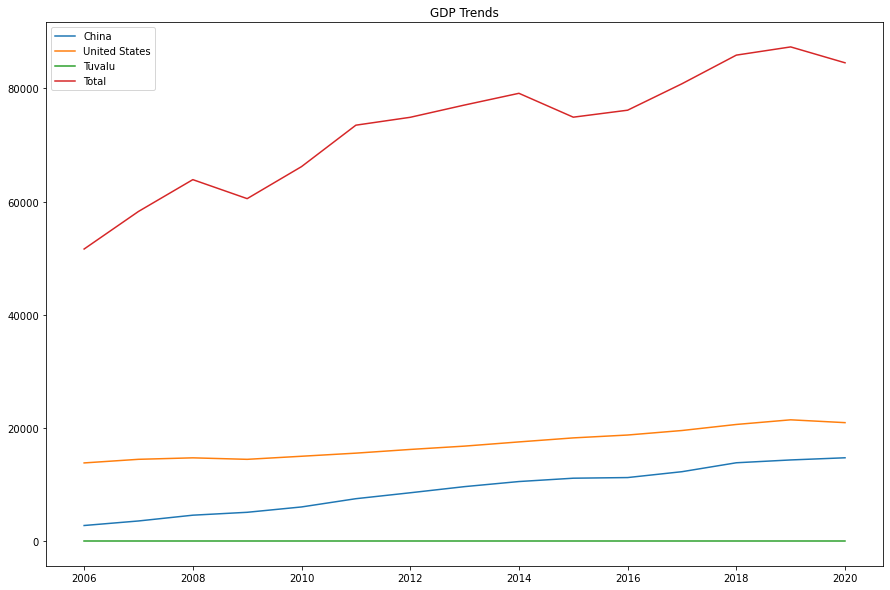

In [185]:
plt.figure(figsize=(15,10))
for i in range(len(df3_gdp)):
    plt.plot(year, df3_gdp.iloc[i,:], label=df3_gdp.index[i])
plt.legend()
plt.title('GDP Trends')
plt.show()

#### We can clearly see that China and United States' growth rate is less than the total GDP. But all of them is growth.

##### 4.5.2 Change data from wide to long

In [186]:
# Before we chnage it to long data, we need to add a new index name for country
df3_gdp.index.name = 'country'# add the index name
def8 = df3_gdp.reset_index()
def8

,country,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,China,2754.113,3555.679,4577.397,5088.993,6033.813,7492.257,8539.472,9625.044,10524.211,11113.528,11227.075,12265.317,13841.901,14340.600,14722.837
1,United States,13814.600,14451.875,14712.825,14448.925,14992.050,15542.600,16197.050,16784.825,17527.275,18238.300,18745.100,19542.975,20611.875,21433.225,20932.750
2,Tuvalu,0.023,0.027,0.031,0.027,0.031,0.038,0.037,0.037,0.037,0.035,0.040,0.043,0.046,0.047,0.048
3,Total,51617.631,58255.141,63878.933,60521.429,66180.940,73503.345,74895.977,77065.298,79135.962,74917.721,76151.185,80825.686,85884.016,87336.213,84528.682


In [187]:
grouped = pd.melt(def8,["country"],var_name="year",value_name="GDP")
grouped = grouped.sort_values(by=["country", "year"])
grouped1 = grouped.groupby([grouped['country'],grouped['year']])
grouped1.sum()

GDP
country       year           
China         2006   2754.113
              2007   3555.679
              2008   4577.397
              2009   5088.993
              2010   6033.813
              2011   7492.257
              2012   8539.472
              2013   9625.044
              2014  10524.211
              2015  11113.528
              2016  11227.075
              2017  12265.317
              2018  13841.901
              2019  14340.600
              2020  14722.837
Total         2006  51617.631
              2007  58255.141
              2008  63878.933
              2009  60521.429
              2010  66180.940
              2011  73503.345
              2012  74895.977
              2013  77065.298
              2014  79135.962
              2015  74917.721
              2016  76151.185
              2017  80825.686
              2018  85884.016
              2019  87336.213
              2020  84528.682
Tuvalu        2006      0.023
              2007      0.027
              2008      0.031
              2009      0.027
              2010      0.031
              2011      0.038
              2012      0.037
              2013      0.037
              2014      0.037
              2015      0.035
              2016      0.040
              2017      0.043
              2018      0.046
              2019      0.047
              2020      0.048
United States 2006  13814.600
              2007  14451.875
              2008  14712.825
              2009  14448.925
              2010  14992.050
              2011  15542.600
              2012  16197.050
              2013  16784.825
              2014  17527.275
              2015  18238.300
              2016  18745.100
              2017  19542.975
              2018  20611.875
              2019  21433.225
              2020  20932.750

#### Because we let the columns only have a variable and it's easier to observed the GDP data of different countries in different years. Their presidential Trends are increasing and it's important for our later analysis. Because we know the trends of GDP, we can use feature scaling to compare with other indicators although sometimes GDP is small due to its large unit. But we only need to observe its trends rather than its large or small number.

In [188]:
grouped2 = grouped.groupby([grouped['country']])
grouped2.sum()

,GDP
country,
China,135702.237
Total,1094698.159
Tuvalu,0.547
United States,257976.250


#### How small number Tuvalu is. But if it also has the same relationship as other countries with other indicators, it can stronger to distinguish the relationship between these indicators.

#### 4.6 We will get the Chinese, United States, Nauru, Tuvalu's data from The World Bank Data

In [189]:
def datadeal(data):
    '''
    This method will use to clean the data from the the World Bank Data's webapi.
    ----------------------------------------------------
    This method will return the data which is only include the useful data
    '''
    data_value = []
    for i in data[1]:
        data_value.append(i['value'])
    return data_value[::-1]
    

In [190]:
#CHN   USA   TUV:Tuvalu
'''
This is the code of WebApi and it will be referenced follow.

1.CO2 emissions (kt) EN.ATM.CO2E.KT
2.Commercial service exports (current US$) TX.VAL.SERV.CD.WT
3.Commercial service imports (current US$) TM.VAL.SERV.CD.WT
4.Communications, computer, etc. (% of service exports, BoP) BX.GSR.CMCP.ZS
5.Communications, computer, etc. (% of service imports, BoP) BM.GSR.CMCP.ZS
6.Current health expenditure per capita (current US$) SH.XPD.CHEX.PC.CD

'''


'\nThis is the code of WebApi and it will be referenced follow.\n\n1.CO2 emissions (kt) EN.ATM.CO2E.KT\n2.Commercial service exports (current US$) TX.VAL.SERV.CD.WT\n3.Commercial service imports (current US$) TM.VAL.SERV.CD.WT\n4.Communications, computer, etc. (% of service exports, BoP) BX.GSR.CMCP.ZS\n5.Communications, computer, etc. (% of service imports, BoP) BM.GSR.CMCP.ZS\n6.Current health expenditure per capita (current US$) SH.XPD.CHEX.PC.CD\n\n'

#### The WebApi required such code to add to the URL. The string means the meaning of the data and the code such as TX.VAL.SERV.CD.WT is used to tell the website which data you want. By the way, CHN, USA and TUV are used to identify the country and they also need to add to the URL.

##### 4.6.1 China indicator, we use URL to get data from the WebApi and extract the data from it.

In [191]:
# China CO2 emissions (kt)
China1 = requests.get('http://api.worldbank.org/v2/country/CHN/indicator/EN.ATM.CO2E.KT?date=2006:2020&format=json')
res1 = China1.json()
China_CO1 = datadeal(res1)
# China Commercial service exports (current US$)
China2 = requests.get('http://api.worldbank.org/v2/country/CHN/indicator/TX.VAL.SERV.CD.WT?date=2006:2020&format=json')
res2 = China2.json()
China_CO2 = datadeal(res2)
# China Commercial service imports (current US$)
China3 = requests.get('http://api.worldbank.org/v2/country/CHN/indicator/TM.VAL.SERV.CD.WT?date=2006:2020&format=json')
res3 = China3.json()
China_CO3 = datadeal(res3)
# China Communications, computer, etc. (% of service exports, BoP)
China4 = requests.get('http://api.worldbank.org/v2/country/CHN/indicator/BX.GSR.CMCP.ZS?date=2006:2020&format=json')
res4 = China4.json()
China_CO4 = datadeal(res4)
# China Communications, computer, etc. (% of service imports, BoP) 
China5 = requests.get('http://api.worldbank.org/v2/country/CHN/indicator/BM.GSR.CMCP.ZS?date=2006:2020&format=json')
res5 = China5.json()
China_CO5 = datadeal(res5)
# China Current health expenditure per capita (current US$)
China6 = requests.get('http://api.worldbank.org/v2/country/CHN/indicator/SH.XPD.CHEX.PC.CD?date=2006:2020&format=json')
res6 = China6.json()
China_CO6 = datadeal(res6)

In [192]:
China_CO6# what the extracting data is.

[81.22816467,
 97.07929993,
 131.88728333,
 162.61755371,
 186.49150085,
 236.37492371,
 281.67715454,
 326.04159546,
 359.30932617,
 390.10409546,
 395.35995483,
 437.25674438,
 501.05938721,
 None,
 None]

### 4.6.2 USA indicator

In [193]:
# USA CO2 emissions (kt)
USA1 = requests.get('http://api.worldbank.org/v2/country/USA/indicator/EN.ATM.CO2E.KT?date=2006:2020&format=json').json()
USA_CO1 = datadeal(USA1)
# USA Commercial service exports (current US$)
USA2 = requests.get('http://api.worldbank.org/v2/country/USA/indicator/TX.VAL.SERV.CD.WT?date=2006:2020&format=json').json()
USA_CO2 = datadeal(USA2)
# USA Commercial service imports (current US$)
USA3 = requests.get('http://api.worldbank.org/v2/country/USA/indicator/TM.VAL.SERV.CD.WT?date=2006:2020&format=json').json()
USA_CO3 = datadeal(USA3)
# USA Communications, computer, etc. (% of service exports, BoP)
USA4 = requests.get('http://api.worldbank.org/v2/country/USA/indicator/BX.GSR.CMCP.ZS?date=2006:2020&format=json').json()
USA_CO4 = datadeal(USA4)
# USA Communications, computer, etc. (% of service imports, BoP) 
USA5 = requests.get('http://api.worldbank.org/v2/country/USA/indicator/BM.GSR.CMCP.ZS?date=2006:2020&format=json').json()
USA_CO5 = datadeal(USA5)
# USA Current health expenditure per capita (current US$)
USA6 = requests.get('http://api.worldbank.org/v2/country/USA/indicator/SH.XPD.CHEX.PC.CD?date=2006:2020&format=json').json()
USA_CO6 = datadeal(USA6)

In [194]:
print(USA_CO6)

[6821.10742188, 7172.16601563, 7410.70068359, 7681.24755859, 7930.15136719, 8130.75634766, 8399.23925781, 8599.52734375, 9023.61132813, 9491.09082031, 9877.87109375, 10209.63085938, 10623.84960938, None, None]


##### 4.6.3 TUV indicator

In [195]:
# TUV CO2 emissions (kt)
TUV1 = requests.get('http://api.worldbank.org/v2/country/TUV/indicator/EN.ATM.CO2E.KT?date=2006:2020&format=json').json()
TUV_CO1 = datadeal(TUV1)
# TUV Commercial service exports (current US$)
TUV2 = requests.get('http://api.worldbank.org/v2/country/TUV/indicator/TX.VAL.SERV.CD.WT?date=2006:2020&format=json').json()
TUV_CO2 = datadeal(TUV2)
# TUV Commercial service imports (current US$)
TUV3 = requests.get('http://api.worldbank.org/v2/country/TUV/indicator/TM.VAL.SERV.CD.WT?date=2006:2020&format=json').json()
TUV_CO3 = datadeal(TUV3)
# TUV Communications, computer, etc. (% of service exports, BoP)
TUV4 = requests.get('http://api.worldbank.org/v2/country/TUV/indicator/BX.GSR.CMCP.ZS?date=2006:2020&format=json').json()
TUV_CO4 = datadeal(TUV4)
# TUV Communications, computer, etc. (% of service imports, BoP) 
TUV5 = requests.get('http://api.worldbank.org/v2/country/TUV/indicator/BM.GSR.CMCP.ZS?date=2006:2020&format=json').json()
TUV_CO5 = datadeal(TUV5)
# TUV Current health expenditure per capita (current US$)
TUV6 = requests.get('http://api.worldbank.org/v2/country/TUV/indicator/SH.XPD.CHEX.PC.CD?date=2006:2020&format=json').json()
TUV_CO6 = datadeal(TUV6)

#### From 4.6.1-4.6.3, this code is used to get three country's data about other indicators such as CO2 and so on.

##  5.Prepped Data Review. 
Here, all the data is ready and we can use them to work.
- GDP data: df3_gdp
- China indicators: China_CO1,China_CO2,China_CO3,China_CO4,China_CO5,China_CO6
- USA indicators: USA_CO1,USA_CO2,USA_CO3,USA_CO4,USA_CO5,USA_CO6
- TUV indicators:TUV_CO1,TUV_CO2,TUV_CO3,TUV_CO4,TUV_CO5,TUV_CO6

#### 5.1 The next step is to put the same country data into the same Pandas dataset and use them for analysis. But for different countries, use these data to create three Pandas respectively for them, then use these Pandas to analyze.

##### 5.1.1 create China Pandas data and fill the NaN data with the 0. Because we need to observe the data trends so we can't use the mean or mid. In this part, I think the 0 is best because 0 will let the data down quickly and we can ignore these parts of the data.

In [196]:
China_d = {'GDP':df3_gdp.iloc[0,:],'CO2 emissions':China_CO1, 'service exports':China_CO2, 'service imports':China_CO3, 
           'computer service exports' :China_CO4, 'computer service imports' :China_CO5, 'health expenditure':China_CO6}
df_china = pd.DataFrame(China_d, index=year)
df_china = df_china.stack()
df_china = df_china.unstack(0)
df_china = df_china.fillna(0)
df_china

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
GDP,2.754113e+03,3.555679e+03,4.577397e+03,5.088993e+03,6.033813e+03,7.492257e+03,8.539472e+03,9.625044e+03,1.052421e+04,1.111353e+04,1.122708e+04,1.226532e+04,1.384190e+04,1.434060e+04,14722.837
CO2 emissions,6.529292e+06,6.697654e+06,7.553070e+06,7.557790e+06,8.776040e+06,9.733538e+06,1.002857e+07,1.025801e+07,1.029193e+07,1.014500e+07,9.893038e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000
service exports,9.349230e+10,1.248942e+11,1.446771e+11,1.216140e+11,1.165775e+11,2.002942e+11,2.005856e+11,2.057782e+11,2.180865e+11,2.163349e+11,2.071921e+11,2.113642e+11,2.318095e+11,2.427723e+11,0.000
service imports,1.003318e+11,1.282692e+11,1.554768e+11,1.451394e+11,1.397866e+11,2.467793e+11,2.802603e+11,3.294188e+11,4.308561e+11,4.331537e+11,4.383647e+11,4.685400e+11,5.212631e+11,5.018272e+11,0.000
computer service exports,4.082696e+01,4.444567e+01,4.429878e+01,4.680031e+01,2.931079e+01,5.627839e+01,5.329029e+01,5.338734e+01,5.829552e+01,5.819956e+01,5.897547e+01,6.062457e+01,1.988049e+01,2.025657e+01,0.000
computer service imports,3.215537e+01,3.472810e+01,3.619170e+01,2.997142e+01,4.012775e+00,2.999049e+01,2.521731e+01,2.477967e+01,1.893983e+01,2.045127e+01,2.172154e+01,2.285668e+01,1.047216e+01,1.099067e+01,0.000
health expenditure,8.122816e+01,9.707930e+01,1.318873e+02,1.626176e+02,1.864915e+02,2.363749e+02,2.816772e+02,3.260416e+02,3.593093e+02,3.901041e+02,3.953600e+02,4.372567e+02,5.010594e+02,0.000000e+00,0.000


##### 5.1.2 create USA Pandas data and fill the NaN data with the 0. Because we need to observe the data trends so we can't use the mean or mid.  In this part, I think the 0 is best because 0 will let the data down quickly and we can ignore these parts of the data.

In [197]:
USA_d = {'GDP':df3_gdp.iloc[1,:],'CO2 emissions':USA_CO1, 'service exports':USA_CO2, 'service imports':USA_CO3, 
           'computer service exports' :USA_CO4, 'computer service imports' :USA_CO5, 'health expenditure':USA_CO6}
df_USA = pd.DataFrame(USA_d, index=year)
df_USA = df_USA.stack()
df_USA = df_USA.unstack(0)
df_USA = df_USA.fillna(0)
df_USA

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
GDP,1.381460e+04,1.445188e+04,1.471283e+04,1.444892e+04,1.499205e+04,1.554260e+04,1.619705e+04,1.678483e+04,1.752728e+04,1.823830e+04,1.874510e+04,1.954297e+04,2.061188e+04,2.143322e+04,20932.75
CO2 emissions,5.697286e+06,5.789031e+06,5.614111e+06,5.263505e+06,5.395532e+06,5.270047e+06,5.082000e+06,5.170360e+06,5.225413e+06,5.126913e+06,5.006302e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.00
service exports,4.038650e+11,4.747370e+11,5.217060e+11,5.019200e+11,5.628350e+11,6.231990e+11,6.626740e+11,6.976790e+11,7.370080e+11,7.482780e+11,7.617510e+11,8.104640e+11,8.404840e+11,8.532750e+11,0.00
service imports,3.219770e+11,3.572040e+11,3.917700e+11,3.760810e+11,4.044900e+11,4.268960e+11,4.417500e+11,4.404770e+11,4.666950e+11,4.762300e+11,4.903960e+11,5.227860e+11,5.390940e+11,5.642800e+11,0.00
computer service exports,4.715755e+01,4.759915e+01,4.699162e+01,4.954025e+01,4.706114e+01,4.773395e+01,4.704624e+01,4.592478e+01,4.523300e+01,4.578410e+01,4.624857e+01,4.643095e+01,2.266590e+01,2.219438e+01,0.00
computer service imports,3.661284e+01,3.659528e+01,3.847973e+01,4.150773e+01,4.045412e+01,4.301260e+01,4.268128e+01,4.376053e+01,4.306907e+01,4.324083e+01,4.341735e+01,4.353059e+01,1.714754e+01,1.650427e+01,0.00
health expenditure,6.821107e+03,7.172166e+03,7.410701e+03,7.681248e+03,7.930151e+03,8.130756e+03,8.399239e+03,8.599527e+03,9.023611e+03,9.491091e+03,9.877871e+03,1.020963e+04,1.062385e+04,0.000000e+00,0.00


##### 5.1.3 create TUV Pandas data and fill the NaN data with the 0. Because we need to observe the data trends so we can't use the mean or mid. In this part, I think the 0 is best because 0 will let the data down quickly and we can ignore these parts of the data.

In [198]:
TUV_d = {'GDP':df3_gdp.iloc[2,:],'CO2 emissions':TUV_CO1, 'service exports':TUV_CO2, 'service imports':TUV_CO3, 
           'computer service exports' :TUV_CO4, 'computer service imports' :TUV_CO5, 'health expenditure':TUV_CO6}
df_TUV = pd.DataFrame(TUV_d, index=year)
df_TUV = df_TUV.stack()
df_TUV = df_TUV.unstack(0)
df_TUV = df_TUV.fillna(0)
df_TUV

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
GDP,2.300000e-02,2.700000e-02,3.100000e-02,2.700000e-02,3.100000e-02,3.800000e-02,3.700000e-02,3.700000e-02,0.037000,0.035000,0.040000,0.043000,0.046000,0.047,0.048
CO2 emissions,7.334000e+00,1.100100e+01,1.100100e+01,1.100100e+01,7.334000e+00,7.334000e+00,1.100100e+01,1.100100e+01,11.001000,11.001000,11.001000,0.000000,0.000000,0.000,0.000
service exports,2.061281e+06,2.274363e+06,2.699715e+06,2.271531e+06,3.185759e+06,3.393629e+06,3.568737e+06,3.254374e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
service imports,9.659776e+06,2.027559e+07,2.304053e+07,1.883692e+07,2.580230e+07,3.475947e+07,2.537129e+07,1.712497e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
computer service exports,3.786798e+01,3.658250e+01,3.609646e+01,3.598686e+01,3.213351e+01,3.395685e+01,3.114974e+01,3.237649e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
computer service imports,3.062072e+01,5.814770e+01,5.928689e+01,6.103190e+01,6.202602e+01,6.551225e+01,4.660642e+01,3.828187e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000
health expenditure,2.986590e+02,2.952989e+02,3.144863e+02,3.759711e+02,5.000560e+02,5.674742e+02,5.320466e+02,6.286420e+02,567.964111,531.266479,547.898438,633.361084,692.521118,0.000,0.000


#### In part 5, we get three pandas dataset which each dataset can verification the relationship between these indicators, and three data set can have more persuasive.

## 6. Investigative Analysis & Results. 
Here we finish 80% of the work in data analysis to prepare data and start the rest 20% of the analysis work. For analysis, we use a line chart to observe the relationship between each Pandas date set.

#### 6.1 Use China data to see the relationship between the data.

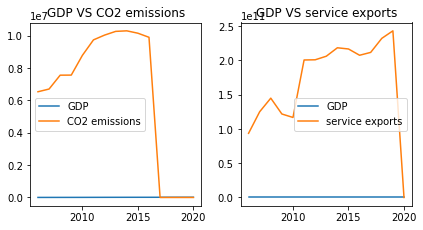

In [199]:
plt.figure(figsize = (6,6))
plt.subplot(2,2,1)
plt.title('GDP VS CO2 emissions')
plt.plot(year, df_china.iloc[0,:], label=df_china.index[0])
plt.plot(year, df_china.iloc[1,:], label=df_china.index[1])
plt.legend()
plt.subplot(2,2,2)
plt.title('GDP VS service exports')
plt.plot(year, df_china.iloc[0,:], label=df_china.index[0])
plt.plot(year, df_china.iloc[2,:], label=df_china.index[2])
plt.legend()
plt.tight_layout()

#### We can see that because the GDP is too small. We need to scale the number of GDP.

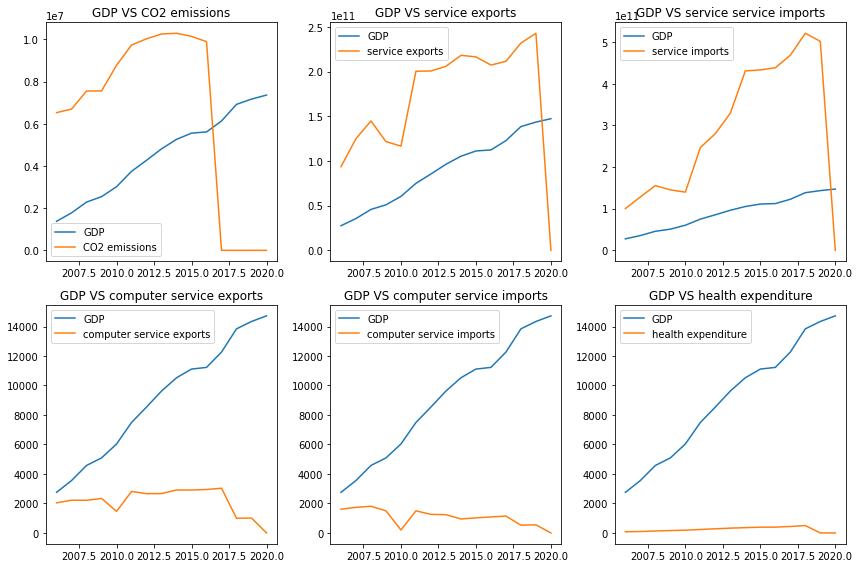

In [200]:
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('GDP VS CO2 emissions')
plt.plot(year, df_china.iloc[0,:]*500, label=df_china.index[0])
plt.plot(year, df_china.iloc[1,:], label=df_china.index[1])
plt.legend()
plt.subplot(2,3,2)
plt.title('GDP VS service exports')
plt.plot(year, df_china.iloc[0,:]*10000000, label=df_china.index[0])
plt.plot(year, df_china.iloc[2,:], label=df_china.index[2])
plt.legend()
plt.subplot(2,3,3)
plt.title('GDP VS service service imports')
plt.plot(year, df_china.iloc[0,:]*10000000, label=df_china.index[0])
plt.plot(year, df_china.iloc[3,:], label=df_china.index[3])
plt.legend()
plt.subplot(2,3,4)
plt.title('GDP VS computer service exports')
plt.plot(year, df_china.iloc[0,:], label=df_china.index[0])
plt.plot(year, df_china.iloc[4,:]*50, label=df_china.index[4])
plt.legend()
plt.subplot(2,3,5)
plt.title('GDP VS computer service imports')
plt.plot(year, df_china.iloc[0,:], label=df_china.index[0])
plt.plot(year, df_china.iloc[5,:]*50, label=df_china.index[5])
plt.legend()
plt.subplot(2,3,6)
plt.title('GDP VS health expenditure')
plt.plot(year, df_china.iloc[0,:], label=df_china.index[0])
plt.plot(year, df_china.iloc[6,:], label=df_china.index[6])
plt.legend()
plt.tight_layout()

#### From the result, in China, we know that CO2 emissions have a positive correlation with GPD. It means that the CO2 emissions will increase as then the GDP increase. service exports and service imports also have a positive correlation with GDP. But computer service exports and computer service imports are hard to confirm the relationship with GDP. Of course, when GDP increase, there is more money can use to support health expenditure and so that there is also a positive correlation.

#### 6.2 Use USA data to see the relationship between the data.

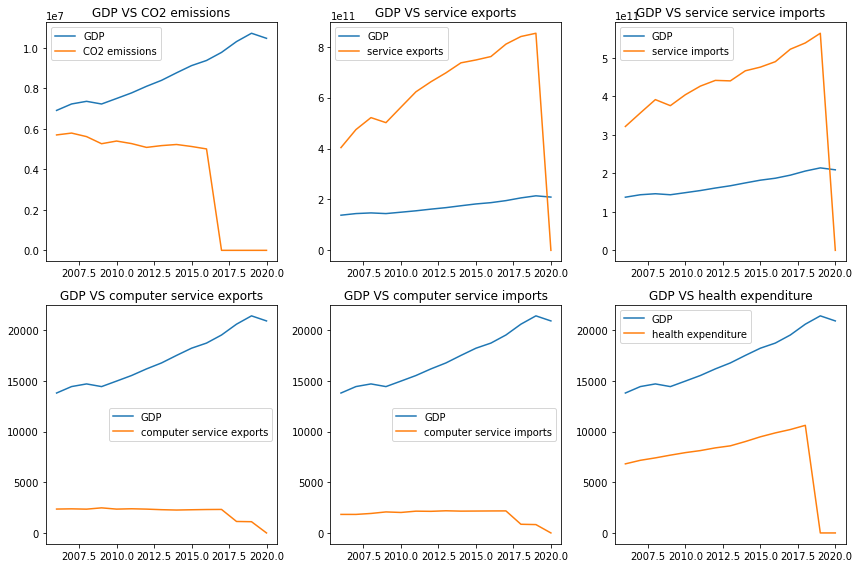

In [201]:
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('GDP VS CO2 emissions')
plt.plot(year, df_USA.iloc[0,:]*500, label=df_USA.index[0])
plt.plot(year, df_USA.iloc[1,:], label=df_USA.index[1])
plt.legend()
plt.subplot(2,3,2)
plt.title('GDP VS service exports')
plt.plot(year, df_USA.iloc[0,:]*10000000, label=df_USA.index[0])
plt.plot(year, df_USA.iloc[2,:], label=df_USA.index[2])
plt.legend()
plt.subplot(2,3,3)
plt.title('GDP VS service service imports')
plt.plot(year, df_USA.iloc[0,:]*10000000, label=df_USA.index[0])
plt.plot(year, df_USA.iloc[3,:], label=df_USA.index[3])
plt.legend()
plt.subplot(2,3,4)
plt.title('GDP VS computer service exports')
plt.plot(year, df_USA.iloc[0,:], label=df_USA.index[0])
plt.plot(year, df_USA.iloc[4,:]*50, label=df_USA.index[4])
plt.legend()
plt.subplot(2,3,5)
plt.title('GDP VS computer service imports')
plt.plot(year, df_USA.iloc[0,:], label=df_USA.index[0])
plt.plot(year, df_USA.iloc[5,:]*50, label=df_USA.index[5])
plt.legend()
plt.subplot(2,3,6)
plt.title('GDP VS health expenditure')
plt.plot(year, df_USA.iloc[0,:], label=df_USA.index[0])
plt.plot(year, df_USA.iloc[6,:], label=df_USA.index[6])
plt.legend()
plt.tight_layout()

#### In the USA, GDP has a negative correlation with CO2 emissions. But we can clearly see that the GDP has the positive correlation  with the health expenditure and service exports and service imports.

#### 6.3 Use TUV data to see the relationship between the data.

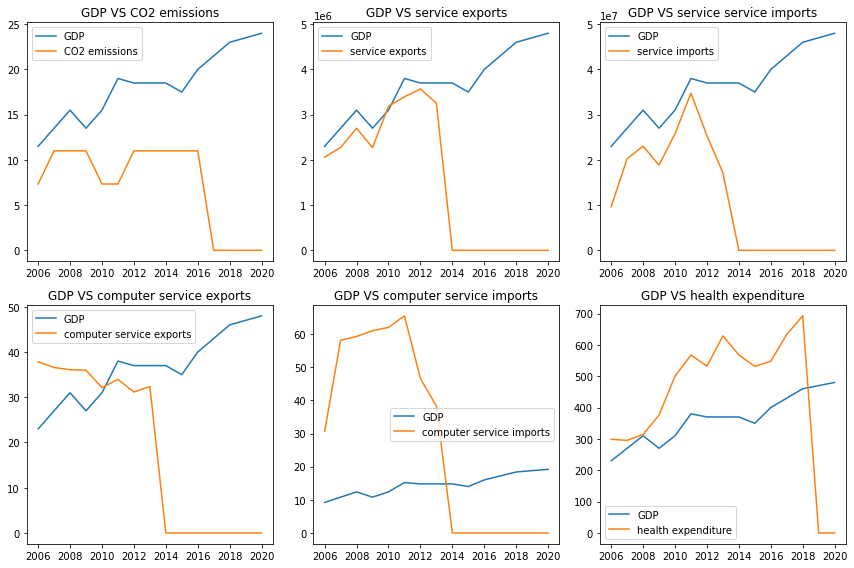

In [202]:
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('GDP VS CO2 emissions')
plt.plot(year, df_TUV.iloc[0,:]*500, label=df_TUV.index[0])
plt.plot(year, df_TUV.iloc[1,:], label=df_TUV.index[1])
plt.legend()
plt.subplot(2,3,2)
plt.title('GDP VS service exports')
plt.plot(year, df_TUV.iloc[0,:]*100000000, label=df_TUV.index[0])
plt.plot(year, df_TUV.iloc[2,:], label=df_TUV.index[2])
plt.legend()
plt.subplot(2,3,3)
plt.title('GDP VS service service imports')
plt.plot(year, df_TUV.iloc[0,:]*1000000000, label=df_TUV.index[0])
plt.plot(year, df_TUV.iloc[3,:], label=df_TUV.index[3])
plt.legend()
plt.subplot(2,3,4)
plt.title('GDP VS computer service exports')
plt.plot(year, df_TUV.iloc[0,:]*1000, label=df_TUV.index[0])
plt.plot(year, df_TUV.iloc[4,:], label=df_TUV.index[4])
plt.legend()
plt.subplot(2,3,5)
plt.title('GDP VS computer service imports')
plt.plot(year, df_TUV.iloc[0,:]*400, label=df_TUV.index[0])
plt.plot(year, df_TUV.iloc[5,:], label=df_TUV.index[5])
plt.legend()
plt.subplot(2,3,6)
plt.title('GDP VS health expenditure')
plt.plot(year, df_TUV.iloc[0,:]*10000, label=df_TUV.index[0])
plt.plot(year, df_TUV.iloc[6,:], label=df_TUV.index[6])
plt.legend()
plt.tight_layout()

#### In TUV, there is a little difference. It has a positive correlation with computer service imports, service exports, service imports and health expenditure. The relationship between GDP and  CO2 emissions is hard to observe in TUV and we need to use more tools such as scatter plots to observe them. 

#### 6.4 Use scatter to analyze the relationship between the US GDP and other indicators.

In [203]:
df_USA1 = df_USA
df_USA1.T

,GDP,CO2 emissions,service exports,service imports,computer service exports,computer service imports,health expenditure
2006,13814.600,5697285.888,4.038650e+11,3.219770e+11,47.157552,36.612840,6821.107422
2007,14451.875,5789030.561,4.747370e+11,3.572040e+11,47.599151,36.595281,7172.166016
2008,14712.825,5614110.994,5.217060e+11,3.917700e+11,46.991623,38.479734,7410.700684
2009,14448.925,5263505.457,5.019200e+11,3.760810e+11,49.540250,41.507726,7681.247559
2010,14992.050,5395532.125,5.628350e+11,4.044900e+11,47.061138,40.454118,7930.151367
2011,15542.600,5270047.385,6.231990e+11,4.268960e+11,47.733953,43.012600,8130.756348
2012,16197.050,5081999.958,6.626740e+11,4.417500e+11,47.046240,42.681283,8399.239258
2013,16784.825,5170359.990,6.976790e+11,4.404770e+11,45.924776,43.760533,8599.527344
2014,17527.275,5225412.661,7.370080e+11,4.666950e+11,45.232998,43.069073,9023.611328
2015,18238.300,5126913.374,7.482780e+11,4.762300e+11,45.784100,43.240832,9491.090820


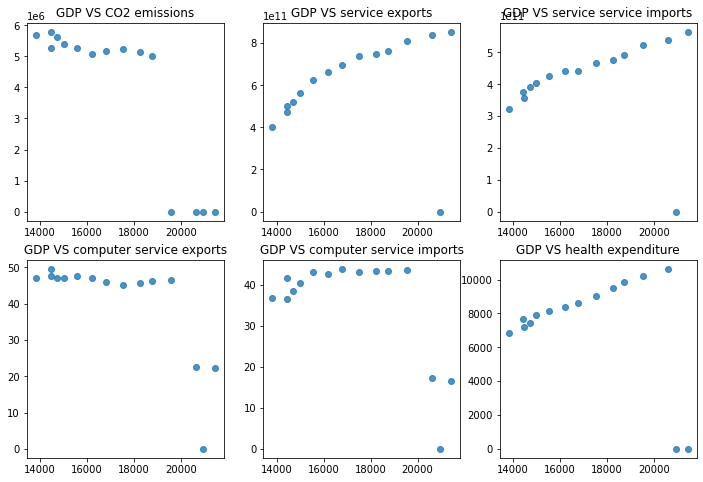

<Figure size 432x288 with 0 Axes>

In [204]:
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('GDP VS CO2 emissions')
plt.scatter(df_USA1.loc['GDP'], df_USA1.loc['CO2 emissions'], alpha=0.8)
plt.subplot(2,3,2)
plt.title('GDP VS service exports')
plt.scatter(df_USA1.loc['GDP'], df_USA1.loc['service exports'], alpha=0.8)
plt.subplot(2,3,3)
plt.title('GDP VS service service imports')
plt.scatter(df_USA1.loc['GDP'], df_USA1.loc['service imports'], alpha=0.8)
plt.subplot(2,3,4)
plt.title('GDP VS computer service exports')
plt.scatter(df_USA1.loc['GDP'], df_USA1.loc['computer service exports'], alpha=0.8)
plt.subplot(2,3,5)
plt.title('GDP VS computer service imports')
plt.scatter(df_USA1.loc['GDP'], df_USA1.loc['computer service imports'], alpha=0.8)
plt.subplot(2,3,6)
plt.title('GDP VS health expenditure')
plt.scatter(df_USA1.loc['GDP'], df_USA1.loc['health expenditure'], alpha=0.8)
plt.show()
plt.tight_layout()

#### Conclusion:  Form the scatter plot, we actually see that as the GDP increase, the US's CO2 emissions decrease. It means that the US is a developed country and tries hard to reduce the CO2 emissions. 

#### 6.5 Use scatter to analyze the relationship between the TUV GDP and other indicators.

In [205]:
df_TUV1 = df_TUV
df_TUV1.T

,GDP,CO2 emissions,service exports,service imports,computer service exports,computer service imports,health expenditure
2006,0.023,7.334,2.061281e+06,9.659776e+06,37.867980,30.620722,298.659027
2007,0.027,11.001,2.274363e+06,2.027559e+07,36.582501,58.147696,295.298859
2008,0.031,11.001,2.699715e+06,2.304053e+07,36.096464,59.286890,314.486328
2009,0.027,11.001,2.271531e+06,1.883692e+07,35.986855,61.031901,375.971069
2010,0.031,7.334,3.185759e+06,2.580230e+07,32.133506,62.026019,500.055969
2011,0.038,7.334,3.393629e+06,3.475947e+07,33.956849,65.512246,567.474243
2012,0.037,11.001,3.568737e+06,2.537129e+07,31.149736,46.606416,532.046631
2013,0.037,11.001,3.254374e+06,1.712497e+07,32.376492,38.281872,628.642029
2014,0.037,11.001,0.000000e+00,0.000000e+00,0.000000,0.000000,567.964111
2015,0.035,11.001,0.000000e+00,0.000000e+00,0.000000,0.000000,531.266479


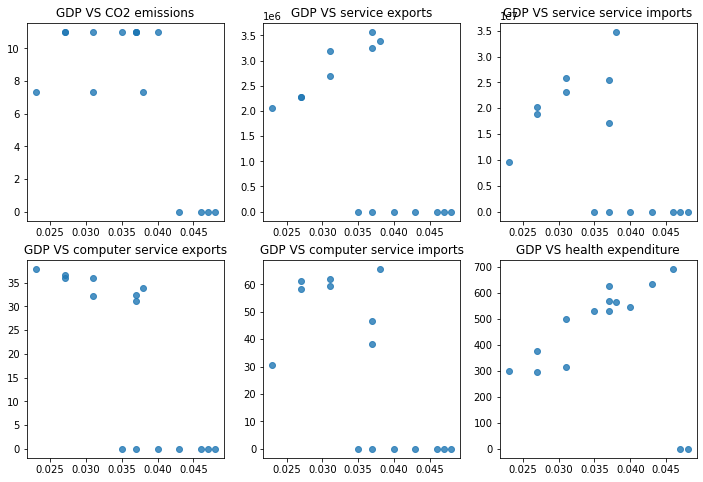

<Figure size 432x288 with 0 Axes>

In [206]:
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('GDP VS CO2 emissions')
plt.scatter(df_TUV1.loc['GDP'], df_TUV1.loc['CO2 emissions'], alpha=0.8)
plt.subplot(2,3,2)
plt.title('GDP VS service exports')
plt.scatter(df_TUV1.loc['GDP'], df_TUV1.loc['service exports'], alpha=0.8)
plt.subplot(2,3,3)
plt.title('GDP VS service service imports')
plt.scatter(df_TUV1.loc['GDP'], df_TUV1.loc['service imports'], alpha=0.8)
plt.subplot(2,3,4)
plt.title('GDP VS computer service exports')
plt.scatter(df_TUV1.loc['GDP'], df_TUV1.loc['computer service exports'], alpha=0.8)
plt.subplot(2,3,5)
plt.title('GDP VS computer service imports')
plt.scatter(df_TUV1.loc['GDP'], df_TUV1.loc['computer service imports'], alpha=0.8)
plt.subplot(2,3,6)
plt.title('GDP VS health expenditure')
plt.scatter(df_TUV1.loc['GDP'], df_TUV1.loc['health expenditure'], alpha=0.8)
plt.show()
plt.tight_layout()

#### Conclusion: We can see that There also hard to see the relationship between GDP and CO2 emissions in TUV. It means that the TUV's GDP growth isn't dependent on the active activities related to carbon dioxide emissions. Of course, when the GPD grows, the health expenditure is also growing and it's beneficial for the people.

#### 6.6 Use scatter to analyze the relationship between the China GDP and other indicators.

In [207]:
df_china1 = df_china
df_china1.T

,GDP,CO2 emissions,service exports,service imports,computer service exports,computer service imports,health expenditure
2006,2754.113,6.529292e+06,9.349230e+10,1.003318e+11,40.826956,32.155368,81.228165
2007,3555.679,6.697654e+06,1.248942e+11,1.282692e+11,44.445668,34.728099,97.079300
2008,4577.397,7.553070e+06,1.446771e+11,1.554768e+11,44.298780,36.191698,131.887283
2009,5088.993,7.557790e+06,1.216140e+11,1.451394e+11,46.800313,29.971422,162.617554
2010,6033.813,8.776040e+06,1.165775e+11,1.397866e+11,29.310793,4.012775,186.491501
2011,7492.257,9.733538e+06,2.002942e+11,2.467793e+11,56.278394,29.990495,236.374924
2012,8539.472,1.002857e+07,2.005856e+11,2.802603e+11,53.290294,25.217311,281.677155
2013,9625.044,1.025801e+07,2.057782e+11,3.294188e+11,53.387342,24.779665,326.041595
2014,10524.211,1.029193e+07,2.180865e+11,4.308561e+11,58.295516,18.939834,359.309326
2015,11113.528,1.014500e+07,2.163349e+11,4.331537e+11,58.199561,20.451268,390.104095


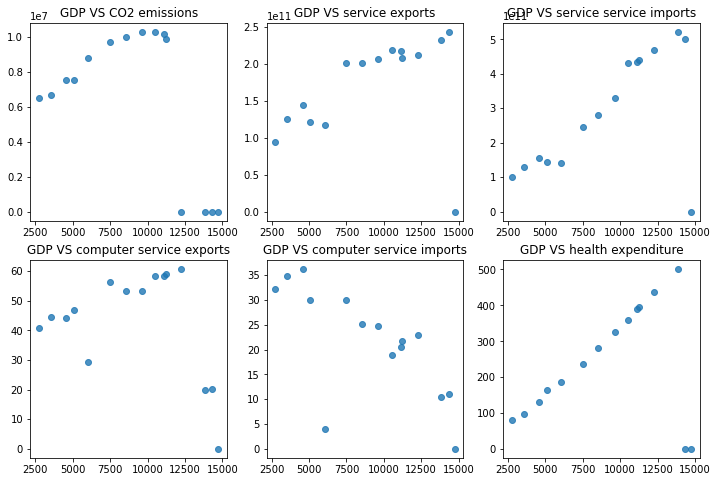

<Figure size 432x288 with 0 Axes>

In [208]:
plt.figure(figsize = (12,8))
plt.subplot(2,3,1)
plt.title('GDP VS CO2 emissions')
plt.scatter(df_china1.loc['GDP'], df_china1.loc['CO2 emissions'], alpha=0.8)
plt.subplot(2,3,2)
plt.title('GDP VS service exports')
plt.scatter(df_china1.loc['GDP'], df_china1.loc['service exports'], alpha=0.8)
plt.subplot(2,3,3)
plt.title('GDP VS service service imports')
plt.scatter(df_china1.loc['GDP'], df_china1.loc['service imports'], alpha=0.8)
plt.subplot(2,3,4)
plt.title('GDP VS computer service exports')
plt.scatter(df_china1.loc['GDP'], df_china1.loc['computer service exports'], alpha=0.8)
plt.subplot(2,3,5)
plt.title('GDP VS computer service imports')
plt.scatter(df_china1.loc['GDP'], df_china1.loc['computer service imports'], alpha=0.8)
plt.subplot(2,3,6)
plt.title('GDP VS health expenditure')
plt.scatter(df_china1.loc['GDP'], df_china1.loc['health expenditure'], alpha=0.8)
plt.show()
plt.tight_layout()

#### Conclusion: We can clearly see that as China's GDP increase, the CO2 emissions' trends is also increasing. But we can see that recently China also try its best to control the CO2 emissions. And like the other country, GDP has a Positive correlation with health expenditure. 

# 7.Conclusions: 
In this project, I answer the question that: Do these six indicators have a relationship with GDP? The answer is that GDP has a positive correlation and a negative correlation with CO2 emissions. It depends on the development process of this country and the efforts made by this country. But for these three-country, we know that GDP always has a positive correlation with health expenditure. So when our GDP increases, we can have better health care. Although TUV's GDP is too low, we can combine it with other countries and know that GDP also has a positive correlation with service exports and service imports. So when our GDP increase will stimulate the service exports and service imports. In the other words, service exports and service imports can help to increase the GDP. So, if we want to let the GDP increase fast, service exports and service imports are an important area to consider. Finally, the relationship between GDP and computer service is hard to confirm. From the result of the line plot and scatter plot, we can know that scatter plot is better to do analysis the 

## 8.Predict the future GDP in 5 years. 
The following is I use TensorFlow to predict the future GDP in 5 years. Although the loss in the model is very large, it still has the same trends to see the GDP in the future.

In [22]:
#Use tensorflow to predict the future GDP
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import keras
import numpy as np

Using TensorFlow backend.


In [23]:
print(year)

[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [24]:
def predictThegdp(data):
    '''
    In thie method, you need to give it the GDP data from 2006 to 2020 and it will return you the predict from 2021 to 2025
    '''
    model = keras.Sequential([keras.layers.Dense(units = 1,input_shape = [1])])
    model.compile(optimizer = 'sgd',loss = 'mean_squared_error')
 
    xs = np.array([i for i in range(15)],dtype = float)# Because the number is too large and I have to Feature scaling
    ys = np.array(data,dtype = float)                  #otheriwse, it will be NaN
    print(xs)
    print(ys)
    print(type(xs))
    print(type(ys))
    model.fit(xs,ys,epochs = 500)
    y_data = []
    y2021 = model.predict([15])
    y2022 = model.predict([16])
    y2023 = model.predict([17])
    y2024 = model.predict([18])
    y2025 = model.predict([19])
    y_data.append(y2021)
    y_data.append(y2022)
    y_data.append(y2023)
    y_data.append(y2024)
    y_data.append(y2025)
    return y_data

In [25]:
China = list(df3_gdp.iloc[0,:])
USA = list(df3_gdp.iloc[1,:])
Tuvalu = list(df3_gdp.iloc[2,:])
Total = list(df3_gdp.iloc[3,:])
China1 = predictThegdp(China)
USA1 = predictThegdp(USA)
Tuvalu1 = predictThegdp(Tuvalu)
Total1 = predictThegdp(Total)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
[ 2754.113  3555.679  4577.397  5088.993  6033.813  7492.257  8539.472
  9625.044 10524.211 11113.528 11227.075 12265.317 13841.901 14340.6
 14722.837]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Epoch 1/500
15/15 [==============================] - 0s 14ms/step - loss: 96828344.0000
Epoch 2/500
15/15 [==============================] - 0s 66us/step - loss: 14960687.0000
Epoch 3/500
15/15 [==============================] - 0s 53us/step - loss: 3862460.7500
Epoch 4/500
15/15 [==============================] - 0s 130us/step - loss: 2341793.0000
Epoch 5/500
15/15 [==============================] - 0s 65us/step - loss: 2117475.7500
Epoch 6/500
15/15 [==============================] - 0s 65us/step - loss: 2068798.1250
Epoch 7/500
15/15 [==============================] - 0s 66us/step - loss: 2044088.7500
Epoch 8/500
15/15 [==============================] - 0s 74us/step - loss: 2022821.2500
Epoch 9/500
15/15 [====================

In [26]:
china_a = China
USA_a = USA
Tuvalu_a = Tuvalu
Total_a = Total
for i in China1:
    china_a.append(i[0][0])
for i in USA1:
    USA_a.append(i[0][0])
for i in Tuvalu1:
    Tuvalu_a.append(i[0][0])
for i in Total1:
    Total_a.append(i[0][0])

In [27]:
year1 = year
year1.extend([2021, 2022, 2023, 2024, 2025])

In [28]:
future_data = pd.DataFrame({'China':china_a, 'USA':USA_a, 'Tuvalu':Tuvalu_a, 'Total':Total_a}, index = year1)
future_data = future_data.stack()
future_data = future_data.unstack(0)
future_data

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
China,2754.113,3555.679,4577.397,5088.993,6033.813,7492.257,8539.472,9625.044,10524.211,11113.528,11227.075,12265.317,13841.901,14340.600,14722.837,16240.045898,17145.205078,18050.363281,18955.521484,19860.679688
USA,13814.600,14451.875,14712.825,14448.925,14992.050,15542.600,16197.050,16784.825,17527.275,18238.300,18745.100,19542.975,20611.875,21433.225,20932.750,22227.746094,22885.164062,23542.582031,24200.000000,24857.417969
Tuvalu,0.023,0.027,0.031,0.027,0.031,0.038,0.037,0.037,0.037,0.035,0.040,0.043,0.046,0.047,0.048,0.045427,0.046301,0.047174,0.048047,0.048920
Total,51617.631,58255.141,63878.933,60521.429,66180.940,73503.345,74895.977,77065.298,79135.962,74917.721,76151.185,80825.686,85884.016,87336.213,84528.682,93103.500000,95743.406250,98383.312500,101023.203125,103663.109375


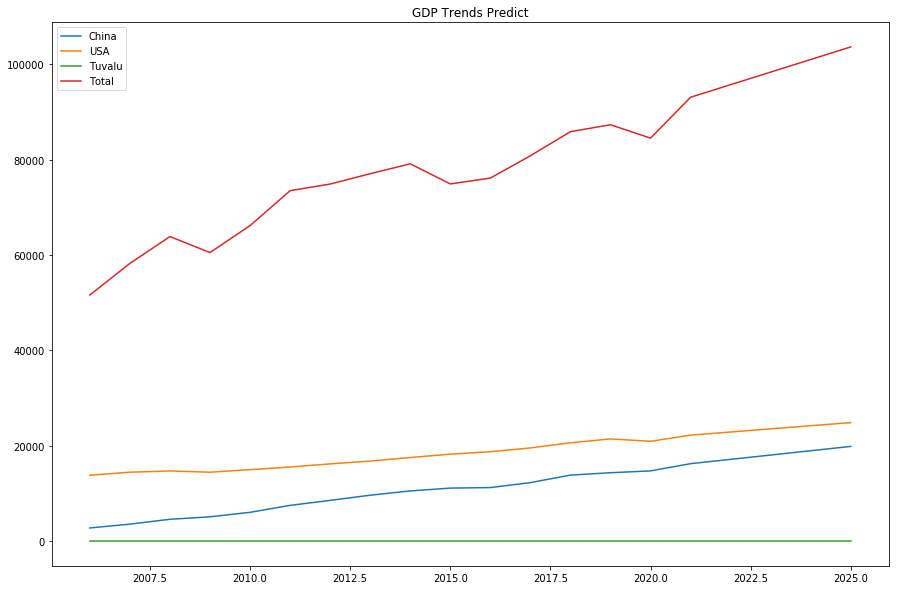

In [30]:
plt.figure(figsize=(15,10))
for i in range(len(future_data)):
    plt.plot(year1, future_data.iloc[i,:], label=future_data.index[i])
plt.legend()
plt.title('GDP Trends Predict')
plt.show()

#### The trends will continue and the Total trends aren't shocking because of the large loss in the model. If we want to get a more accurate prediction we can increase the train steps or using more feature engineering or design the network for it.